# Christoffel module step by step

In [1]:
# import some general scientific Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import required PyRockWave modules
import christoffel as ch
import coordinates as c

The goal of PyRockWave's Christoffel module is to estimate various seismic properties as a function of propagation direction using the Christoffel equation (Christoffel, 1877). These properties include the $V_p$ (compressional), $V_{s1}$, $V_{s2}$ (shear) phase and group sound wave velocities in km/s, the polarisation directions of the sound waves, the shear wave splitting, the coordinates of the ray surface, the power flow angle and the enhancement factor. We will define all these parameters throughout this notebook.

## Input data

The necessary input data to estimate the seismic properties in any direction of a given material using the Christoffel equation are the density and the stiffness tensor of the material.

The stiffness tensor $C$ is a fundamental property of a material that generalises Hooke's law in three dimensions, relating strains to stresses in the elastic regime. This is usually given (or abbreviated) in a 6x6 matrix ($C_{ij}$) using Voigt's notation with values given in $GPa$. Density is usually given in $g/cm^3$.

> _Other material properties unrelated to seismic waves that can be derived from these data are: Young modulus, shear modulus, Poisson's ratio, linear compresibility and Debye temperature._

In [2]:
# load test data
Cij = np.array([[118.8,  53.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8, 118.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8,  53.8, 118.8,   0. ,   0. ,   0. ],
                [  0. ,   0. ,   0. ,  59.4,   0. ,   0. ],
                [  0. ,   0. ,   0. ,   0. ,  59.4,   0. ],
                [  0. ,   0. ,   0. ,   0. ,   0. ,  59.4]])

density = 5.307

## Step 0: create an array with wave vectors

For most materials, the seismic properties are anisotropic, i.e. they depend on the direction. Accordingly, the Christoffel equation must be solved for each propagation direction of interest, and we must first define such a direction, denoted as wave vectors or $q$. Wave vectors can be defined in spherical coordinates (polar and azimuthal angles) or in Cartesian coordinates ($x, y, z$) normalised to the unit sphere (i.e. vector of size 1). Cartesian coordinates are used for calculations. In this case we will use the following procedure:

- Create equispaced wavevectors in spherical coordinates
- Convert from spherical to 3D Cartesian unit vectors
- Store the wavevectors in a single array with three columns ($x, y, z$) for calculations

In [3]:
# create equispaced wavevectors in spherical coordinates (in radians)
azimuths, polar = c.equispaced_S2_grid(n=150)

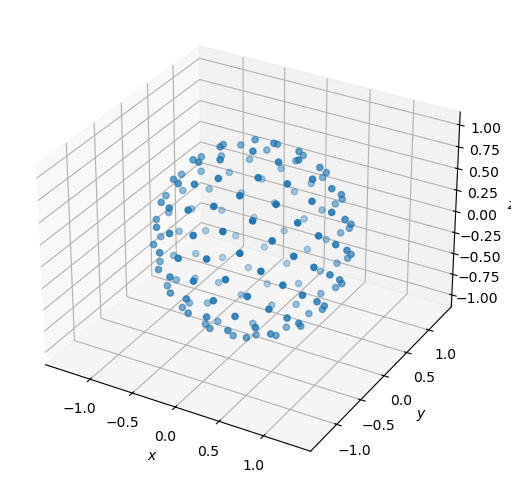

In [4]:
# convert from spherical to 3d cartesian
x, y, z = c.sph2cart(azimuths, polar)

# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)
ax.axis('equal')
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

In [5]:
# Store wavevectors in a single Numpy array for calculations
wavevectors = np.column_stack((x, y, z))

wavevectors.shape

(150, 3)

## Step 1: Rearrange to a tensor $Cij → Cijkl$

The operations to solve the Christoffel equation require the stiffness tensor to be in its tensor format, i.e. with its original form 3x3x3x3 (rank 4, dimension 3), rather than as a 6x6 matrix as normally provided, so it is necessary to convert $C_{ij}$ to $C_{ijkl}$.

In [6]:
Cijkl = ch._rearrange_tensor(Cij)

Cijkl.shape

(3, 3, 3, 3)

## Step 2: Estimate the Christoffel matrices for each wavevector $\vec{q}$

TODO

$$
q_n \, C_{inmj} \, q_m =  \rho \frac{\omega^2}{k^2} s_j
$$

TODO

$$
M_{ij} = \sum_{nm} q_n \, C_{inmj} \, q_m
$$

In [7]:
Mij = ch._christoffel_matrix(wavevectors, Cijkl)

Mij.shape

(150, 3, 3)

## Step 3: Normalize the Christoffel matrices

$$
M_{ij(norm)} = \frac{M_{ij}}{\rho}
$$

In [8]:
scaling_factor = 1 / density
norm_Mij = Mij * scaling_factor

In [9]:
# check
Mij[0], norm_Mij[0]

(array([[ 59.4,   0. ,   0. ],
        [  0. ,  59.4,   0. ],
        [  0. ,   0. , 118.8]]),
 array([[11.19276427,  0.        ,  0.        ],
        [ 0.        , 11.19276427,  0.        ],
        [ 0.        ,  0.        , 22.38552855]]))

## Step 4: Estimate the eigenvalues $\lambda$ and eigenvectors $\vec{v}$

TODO

In [10]:
eigenvalues, eigenvectors = ch._calc_eigen(norm_Mij)

eigenvalues.shape, eigenvectors.shape

((150, 3), (150, 3, 3))

## Step 5: Calculate phase velocities ($v_p$)

The eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ of the Christoffel tensor $M_{ij}$ are always real, positive and related to the phase wave velocities $V_p$, $V_{s1}$, $V_{s2}$ propagating in the direction $\vec{n}$ by the formulae

$$
V_p = \sqrt{ \frac{\lambda_1}{\rho} }, \quad V_{s1} = \sqrt{ \frac{\lambda_2}{\rho} }, \quad V_{s2} = \sqrt{ \frac{\lambda_3}{\rho} }
$$

where $\rho$ denotes the material density. Note that if the Christoffel tensor is already normalized to the density this is just

$$
v_p = \sqrt{\lambda_n}, \quad \lambda_n = v^2_p
$$

where $v_p$ denotes phase velocities and $\lambda_n$ the various eigenvalues. Due to this, the output will be an array of shape $(n, 3)$, where $n$ represents the number of wavevectors (orientations) considered.

> TODO -> define phase velocities

In [11]:
phase_velocities = ch.calc_phase_velocities(eigenvalues)

phase_velocities.shape

(150, 3)

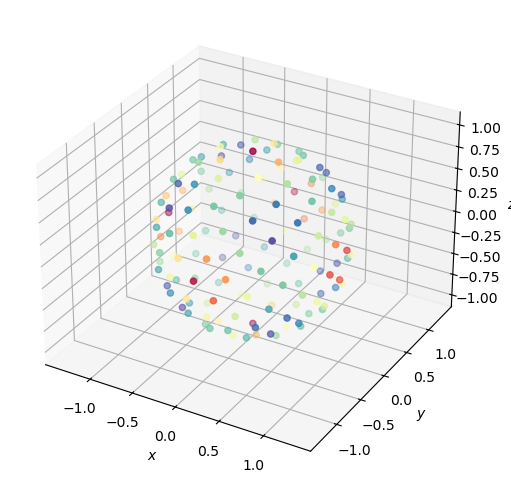

In [12]:
# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z, c=phase_velocities[:, 2], cmap='Spectral')
ax.axis('equal')
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

## Towards group velocities ($v_g$)

> TODO -> Explain group velocities

$$
v_g = \vec{\varDelta} v_p = \vec{\varDelta} \sqrt{\lambda} = \frac{\vec{\varDelta} \lambda}{2 \sqrt{\lambda}} = \frac{\vec{\varDelta} \lambda}{2 v_p}
$$


## Step 6: Calculate the derivatives of the Christoffel matrices ($∇M_{ij}$)

$$
\frac{\partial M_{ij}}{\partial q_k} = \sum_m (C_{ikmj} + C_{imkj}) q_m
$$

In [13]:
dMijk = ch._christoffel_gradient_matrix(wavevectors, Cijkl)

dMijk.shape

(150, 3, 3, 3)

## Step 7: Calculate the derivative of the eigenvalues

The first derivative of an eigenvalue $\lambda$ of a matrix $M$ is given by:

$$
\frac{\partial \lambda_i}{\partial q_k} = \hat{s}_i \cdot \frac{\partial M_{ij}}{\partial q_k} \cdot \hat{s}_i
$$

where $\hat{s}_i$ is the normalized eigenvector corresponding to eigenvalue $\lambda_i$.

In [14]:
eigenvalue_gradients = ch._eigenvalue_derivatives(eigenvectors, dMijk)

eigenvalue_gradients.shape

(150, 3, 3)

## Step 8: Calculate the Group velocities ($v_g$)


### Step 8.1: Calculate group velocity matrices

$$
v_g = \vec{\varDelta} v_p = \vec{\varDelta} \sqrt{\lambda} = \frac{\vec{\varDelta} \lambda}{2 \sqrt{\lambda}} = \frac{\vec{\varDelta} \lambda}{2 v_p}
$$

In [15]:
phase_velocities_reshaped = phase_velocities[:, :, np.newaxis]
group_velocities = eigenvalue_gradients / (2 * phase_velocities_reshaped)

group_velocities.shape

(150, 3, 3)

### Step 8.2: Calculate the magnitudes of group velocities

In [16]:
group_velocity_magnitudes = np.linalg.norm(group_velocities, axis=2)

group_velocity_magnitudes.shape

(150, 3)

In [17]:
group_velocity_magnitudes[:10]

array([[17.75488102, 17.75488102, 25.10919354],
       [35.99857691, 17.75488102, 18.73604019],
       [23.71546689, 15.93965675, 25.80139079],
       [25.85683296, 25.7164817 , 21.00667897],
       [38.32582014, 23.67290383, 16.70527848],
       [45.82012405, 17.9090856 , 14.11017821],
       [35.2777454 , 33.14415795, 13.23232711],
       [21.12066267, 33.4758999 , 19.11855929],
       [17.37894011, 39.37889236, 17.20584666],
       [17.58598758, 17.05472384, 27.54163352]])

> This wave velocities are not normalized by the density of the material!

### Step 8.3: Calculate the directions of group velocities (unit vectors)

In [18]:
epsilon = 1e-10  # Add a small epsilon to avoid division by zero
group_velocity_directions = group_velocities / (group_velocity_magnitudes[:, :, np.newaxis] + epsilon)

group_velocity_directions.shape

(150, 3, 3)

### Step 8.4: Calculate the power flow angles ($\psi$)

The power flow angle is the angle between vector $\vec{n}$ (normal to the slowness surface) and $\vec{l}$ (the direction normal to the wavefront).

TODO

$$
v_p = v_g \, cos(\psi)
$$


In [19]:
cos_power_flow_angles = np.zeros((wavevectors.shape[0], 3))

# TODO: remove using numpy broadcasting rules!!
for i in range(wavevectors.shape[0]):
    cos_power_flow_angles = np.dot(group_velocity_directions, wavevectors[i])

power_flow_angles = np.arccos(np.clip(cos_power_flow_angles, -1, 1))
#power_flow_angles = np.arccos(np.around(cos_power_flow_angles, decimals=10))

power_flow_angles.shape

(150, 3)

## Step 9: Calculate enhacement factor ($A$)

The group velocity direction is the direction in which the energy travels. As this is generally not the same as the phase velocity direction, there will be variations in the power flow concentration as a function of direction. This effect is quantified by a parameter called the _enhancement factor_ defined as

$$
A = \frac{\varDelta\Omega_k}{\varDelta\Omega_g}
$$

TODO

### Step 9.1: Calculate the Hessian of the Christoffel matrix

In [20]:
# TODO

### Step 9.2: Compute the Hessian of eigenvalues

In [21]:
# TODO

### Step 9.3: Determine the enhancement factors

In [22]:
# TODO

## Pandas output

In [23]:
data = pd.DataFrame({
    'polar_ang': np.around(np.rad2deg(polar), 1),
    'azimuthal_ang': np.around(np.rad2deg(azimuths), 1),
    'phase_Vp': phase_velocities[:, 2],
    'phase_Vs1': phase_velocities[:, 1],
    'phase_Vs2': phase_velocities[:, 0],
    'group_Vp': group_velocity_magnitudes[:, 2],
    'group_Vs1': group_velocity_magnitudes[:, 1],
    'group_Vs2': group_velocity_magnitudes[:, 0]
})

In [24]:
data

,polar_ang,azimuthal_ang,phase_Vp,phase_Vs1,phase_Vs2,group_Vp,group_Vs1,group_Vs2
0,0.0,0.0,4.731335,3.345559,3.345559,25.109194,17.754881,17.754881
1,16.9,0.0,4.932846,3.345559,3.040613,18.736040,17.754881,35.998577
2,19.3,222.5,4.988421,3.262362,3.040346,25.801391,15.939657,23.715467
3,21.5,85.0,5.013496,3.343000,2.908654,21.006679,25.716482,25.856833
4,23.4,307.5,5.067123,3.234312,2.938460,16.705278,23.672904,38.325820
...,...,...,...,...,...,...,...,...
145,156.6,358.9,5.045805,3.345408,2.849412,14.947433,17.756937,43.963691
146,158.5,221.4,5.030398,3.244671,2.989694,17.112216,34.244125,26.200725
147,160.7,83.9,4.976185,3.342438,2.972667,22.005111,27.086900,21.335370
148,163.1,306.4,4.940651,3.287877,3.090450,20.656204,31.815502,19.384072


**I think I need to normalize the ``eigenvalue_gradients`` or ``group_velocities``  before calculating the group velocity magnitudes**

In [25]:
(data['group_Vp'] / density) / data['phase_Vp']

0      1.000000
1      0.715700
2      0.974610
3      0.789528
4      0.621217
         ...   
145    0.558196
146    0.640995
147    0.833255
148    0.787802
149    1.000000
Length: 150, dtype: float64

In [26]:
data['group_Vp'] / density

0      4.731335
1      3.530439
2      4.861766
3      3.958296
4      3.147782
         ...   
145    2.816550
146    3.224461
147    4.146431
148    3.892256
149    4.731335
Name: group_Vp, Length: 150, dtype: float64


---
# TEST

In [27]:
def set_group_velocity(phase_vel, eig_vec, gradmat, direction):
    """
    Implementation of group velocities by Jeken and Cottenier
    removing from the Christoffel class and refactored
    """

    # Variables initialization
    grad_eig = np.empty((3, 3))
    group_vel = np.empty((3, 3))
    _group_abs = np.empty(3)
    _group_dir = np.empty((3, 3))
    group_theta = np.empty(3)
    group_phi = np.empty(3)


    for pol in range(3):
        for cart in range(3):
            grad_eig[pol][cart] = np.dot(
                eig_vec[pol], np.dot(gradmat[cart], eig_vec[pol])
            )
            # Eigenvalues are the square of the velocity
            # dv/dq = dv^2/dq / (2v)
            group_vel[pol][cart] = grad_eig[pol][cart] / (2 * phase_vel[pol])
        _group_abs[pol] = np.linalg.norm(group_vel[pol])
        _group_dir[pol] = group_vel[pol] / _group_abs[pol]

        x = _group_dir[pol][0]
        z = _group_dir[pol][2]
        if z >= 1.0 - 1e-10 or z <= -1.0 + 1e-10:
            group_theta[pol] = 0.0
            group_phi[pol] = 0.0
        else:
            group_theta[pol] = np.arccos(z)
            sin_theta = np.sqrt(1 - z**2)
            if abs(x) > sin_theta:
                group_phi[pol] = (1.0 - np.sign(x)) * 0.5 * np.pi
            else:
                group_phi[pol] = np.arccos(x / sin_theta)
            if _group_dir[pol][1] < 0.0:
                group_phi[pol] = 2 * np.pi - group_phi[pol]
    
    _cos_pf_angle = np.dot(_group_dir, direction)
    powflow_angle = np.arccos(np.around(_cos_pf_angle, 10))

    return grad_eig, group_vel, _group_abs, _group_dir, powflow_angle, group_theta, group_phi


In [28]:
res1, res2, res3, res4, res5, thetas, phis = set_group_velocity(phase_velocities[5], eigenvectors[5], dMijk[5], wavevectors[5])

### eigenvalue derivatives

In [29]:
# gradients (derivatives) of eigenvalues
res1

array([[-178.37753156,   31.03136257,  182.78983801],
       [ -50.46603759,  -10.73858839,  107.61372694],
       [  29.37514444,   14.99038156,  139.45976968]])

In [30]:
eigenvalue_gradients[5]  # NICE!

array([[-178.37753156,   31.03136257,  182.78983801],
       [ -50.46603759,  -10.73858839,  107.61372694],
       [  29.37514444,   14.99038156,  139.45976968]])

---

### Group velocity matrices

In [31]:
# Group velocity
res2

array([[-31.7678895 ,   5.52648581,  32.55369286],
       [ -7.57310767,  -1.61146961,  16.14888705],
       [  2.89232996,   1.47598013,  13.73146165]])

In [32]:
group_velocities[5]

array([[-31.7678895 ,   5.52648581,  32.55369286],
       [ -7.57310767,  -1.61146961,  16.14888705],
       [  2.89232996,   1.47598013,  13.73146165]])

---

### Group velocity magnitudes

In [33]:
# magnitude of the group velocity for each mode
res3

array([45.82012405, 17.9090856 , 14.11017821])

In [34]:
group_velocity_magnitudes[5]

array([45.82012405, 17.9090856 , 14.11017821])

---

### Group velocity directions

In [35]:
# direction of the group velocity for each mode
res4

array([[-0.6933174 ,  0.12061263,  0.71046715],
       [-0.42286401, -0.08998056,  0.90171477],
       [ 0.20498182,  0.10460393,  0.97316004]])

In [36]:
group_velocity_directions[5]

array([[-0.6933174 ,  0.12061263,  0.71046715],
       [-0.42286401, -0.08998056,  0.90171477],
       [ 0.20498182,  0.10460393,  0.97316004]])

---

### Powerflow angles

In [37]:
# Powerflow angle (in radians)
res5

array([0.34026944, 0.16446957, 0.64009417])

In [38]:
power_flow_angles[5]

array([2.36095813, 2.69451592, 2.90938203])

---
### Spherical angles (polar, azimuthal == thethas & phis) for a given velocity group directions (3D vectors)

In [39]:
thetas

array([0.78063452, 0.44707674, 0.23221062])

In [40]:
phis

array([2.96935187, 3.35125399, 0.47186024])